# Life Expectancy Estimation

## Goal

The goal of this project is to first analyze the driving factors of life expectancy, and then use machine learning models in order to give an estimate of this feature for a given country.

## Data

The dataset used for this project is the [Life Expectancy Data](https://www.kaggle.com/datasets/lashagoch/life-expectancy-who-updated?select=Life-Expectancy-Data-Updated.csv) from Kaggle, collected by the World Health Organization. It contains 22 features for 193 countries, for a period between 2000 and 2015.  
We have downloaded the `.csv` file and put it in the `data` folder.

## Analysis

These are some important questions we need to discover:
- What are the variables affecting life expectancy?
- What is relationship between infant and adult mortality and life expectancy?
- Is there a positive or negative correlation between life expectancy and drinking habits?
- What is the impact of schooling on the lifespan of humans?
- Do densely populated countries tend to have a lower life expectancy?
- What is the relationship between life expectancy and Immunization coverage?

And much more...

## Import Libraries and Load Data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (5, 5)

In [2]:
# load data
df = pd.read_csv('../data/life_expectancy.csv')

In [3]:
# inspect data
df.head()

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,...,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status_Developed,Economy_status_Developing,Life_expectancy
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,...,97,0.08,11006,78.53,4.9,4.8,7.8,0,1,76.5
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,...,97,0.09,25742,46.44,0.6,0.5,9.7,1,0,82.8
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,...,64,0.13,1076,1183.21,27.1,28.0,5.0,0,1,65.4
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,...,93,0.79,4146,0.75,5.7,5.5,7.9,0,1,67.0
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,...,94,0.08,33995,7.91,1.2,1.1,12.8,1,0,81.7


In [4]:
# inspect the shape and the columns
df.shape, df.columns

((2864, 21),
 Index(['Country', 'Region', 'Year', 'Infant_deaths', 'Under_five_deaths',
        'Adult_mortality', 'Alcohol_consumption', 'Hepatitis_B', 'Measles',
        'BMI', 'Polio', 'Diphtheria', 'Incidents_HIV', 'GDP_per_capita',
        'Population_mln', 'Thinness_ten_nineteen_years',
        'Thinness_five_nine_years', 'Schooling', 'Economy_status_Developed',
        'Economy_status_Developing', 'Life_expectancy'],
       dtype='object'))

In [5]:
# change column names to lower case
df.columns = df.columns.str.lower()

In [6]:
# change some columns labels for simplicity
df.rename(columns={
    'under_five_deaths': 'kid_deaths',
    'adult_mortality': 'adult_deaths',
    'alcohol_consumption': 'alcohol',
    'gdp_per_capita': 'income',
    'life_expectancy': 'lifespan',
    'thinness_ten_nineteen_years': 'thinness_teen',
    'thinness_five_nine_years': 'thinness_kid',
}, inplace=True)

We see that the two columns economy_status_developed and economy_status_developing are redundant, let's create a new column called status, and drop the two others.

In [7]:
# create status column
df['status'] = df['economy_status_developed'].apply(lambda x: 'developed' if x==1 else 'developing')
df.drop(['economy_status_developed', 'economy_status_developing'], axis=1, inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2864 entries, 0 to 2863
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         2864 non-null   object 
 1   region          2864 non-null   object 
 2   year            2864 non-null   int64  
 3   infant_deaths   2864 non-null   float64
 4   kid_deaths      2864 non-null   float64
 5   adult_deaths    2864 non-null   float64
 6   alcohol         2864 non-null   float64
 7   hepatitis_b     2864 non-null   int64  
 8   measles         2864 non-null   int64  
 9   bmi             2864 non-null   float64
 10  polio           2864 non-null   int64  
 11  diphtheria      2864 non-null   int64  
 12  incidents_hiv   2864 non-null   float64
 13  income          2864 non-null   int64  
 14  population_mln  2864 non-null   float64
 15  thinness_teen   2864 non-null   float64
 16  thinness_kid    2864 non-null   float64
 17  schooling       2864 non-null   f

Right now, we have 20 features:

- The target feature which is `life_expectancy`
- `country`, `region` and `status` which are categorical features
- The 16 others are numerical features

We also see that there are no missing values in the dataset, which is great.

In [9]:
# look at the missing values
df.isna().sum()

country           0
region            0
year              0
infant_deaths     0
kid_deaths        0
adult_deaths      0
alcohol           0
hepatitis_b       0
measles           0
bmi               0
polio             0
diphtheria        0
incidents_hiv     0
income            0
population_mln    0
thinness_teen     0
thinness_kid      0
schooling         0
lifespan          0
status            0
dtype: int64

## Explore and Explain Data

In this section, we will to answer the questions we have asked in the introduction of the notebook, so that the model building process can be more efficient.

Our dataset contains data for 179 countries, these countries are distributed across 9 regions.  
For each country, there are 16 records, one for each year between 2000 and 2015.

In [10]:
df[['country']].value_counts(), df[['region']].value_counts()

(country    
 Afghanistan    16
 Rwanda         16
 Nepal          16
 Netherlands    16
 New Zealand    16
                ..
 Georgia        16
 Germany        16
 Ghana          16
 Greece         16
 Zimbabwe       16
 Length: 179, dtype: int64,
 region                       
 Africa                           816
 Asia                             432
 European Union                   432
 Central America and Caribbean    304
 Rest of Europe                   240
 Middle East                      224
 South America                    192
 Oceania                          176
 North America                     48
 dtype: int64)

In [11]:
# summary statistics
df.describe()

,year,infant_deaths,kid_deaths,adult_deaths,alcohol,hepatitis_b,measles,bmi,polio,diphtheria,incidents_hiv,income,population_mln,thinness_teen,thinness_kid,schooling,lifespan
count,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000,2864.000000
mean,2007.500000,30.363792,42.938268,192.251775,4.820882,84.292598,77.344972,25.032926,86.499651,86.271648,0.894288,11540.924930,36.675915,4.865852,4.899825,7.632123,68.856075
std,4.610577,27.538117,44.569974,114.910281,3.981949,15.995511,18.659693,2.193905,15.080365,15.534225,2.381389,16934.788931,136.485867,4.438234,4.525217,3.171556,9.405608
min,2000.000000,1.800000,2.300000,49.384000,0.000000,12.000000,10.000000,19.800000,8.000000,16.000000,0.010000,148.000000,0.080000,0.100000,0.100000,1.100000,39.400000
25%,2003.750000,8.100000,9.675000,106.910250,1.200000,78.000000,64.000000,23.200000,81.000000,81.000000,0.080000,1415.750000,2.097500,1.600000,1.600000,5.100000,62.700000
50%,2007.500000,19.600000,23.100000,163.841500,4.020000,89.000000,83.000000,25.500000,93.000000,93.000000,0.150000,4217.000000,7.850000,3.300000,3.400000,7.800000,71.400000
75%,2011.250000,47.350000,66.000000,246.791375,7.777500,96.000000,93.000000,26.400000,97.000000,97.000000,0.460000,12557.000000,23.687500,7.200000,7.300000,10.300000,75.400000
max,2015.000000,138.100000,224.900000,719.360500,17.870000,99.000000,99.000000,32.100000,99.000000,99.000000,21.680000,112418.000000,1379.860000,27.700000,28.600000,14.100000,83.800000


Let's start our exploration journey with a global view.  
First we look at the distribution of the target feature `life_expectancy`, and how it is split across the status of the countries.

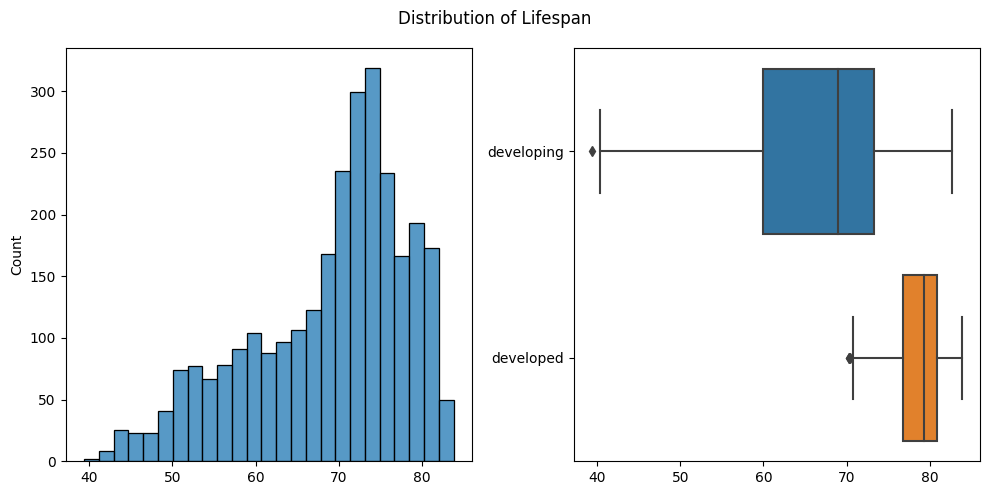

In [12]:
# histogram and boxplot of lifespan

# create figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# plot histogram and boxplot
sns.histplot(df['lifespan'], ax=ax[0])
sns.boxplot(x = df['lifespan'], y=df['status'],ax=ax[1])

# adjust the graph
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
plt.suptitle('Distribution of Lifespan')
plt.tight_layout()
plt.show()

In [13]:
# the distribution of status of the countries
df['status'].value_counts()

developing    2272
developed      592
Name: status, dtype: int64

The plots above show that the distribution of lifespan is left skewed, with a mid value of around 70 years. As of the distribution across the status of the countries, we see that the developed countries significantly differ from the developing ones, the mean is a lot higher for the developed countries, this means that countries that are classified as developed are a lot more likely to have a higher life expectancy.  
Now that we saw how our target variable is distributed in our dataset, let's look at a global view of lifespan and annual income, the evolution over the years and the spread across regions.

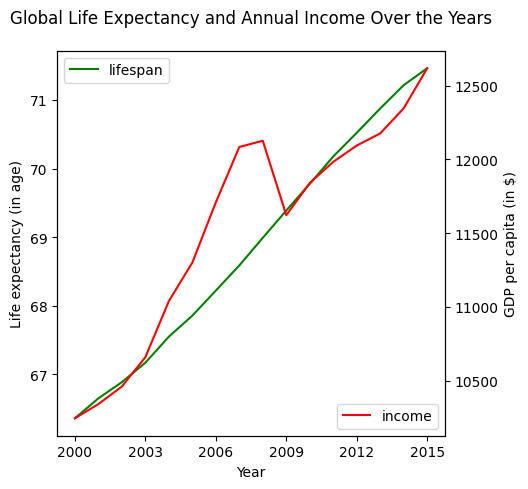

In [14]:
# the global evolution of life expectancy and GDP per capita over the years
temp_df = df.groupby('year')

# initialize the figure
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# plot the lines
ax1.plot(temp_df['lifespan'].mean(), color='green', label='lifespan')
ax2.plot(temp_df['income'].mean(), color='red', label='income')

# adjust the plot
ax1.set_xticks([i for i in range(2000, 2016, 3)])
ax1.set_xlabel('Year')
ax1.set_ylabel('Life expectancy (in age)')
ax1.legend(loc='upper left')
ax2.set_ylabel('GDP per capita (in $)')
ax2.legend(loc='lower right')
plt.title('Global Life Expectancy and Annual Income Over the Years', y=1.05)
plt.show()


- We see that for life expectancy is increasing over the years, it follows a straight line, starting from around 62 years at 2000 to reach 72 years at 2015.  
- Concering GDP per capita, meaning the average annual income of a person in a country, we see that it is also increasing over the years, notice the drop in 2008, this is due to the financial crisis.

Keeping up with the global view, let's try to see the distribution of life expectancy and Annual income across the regions.

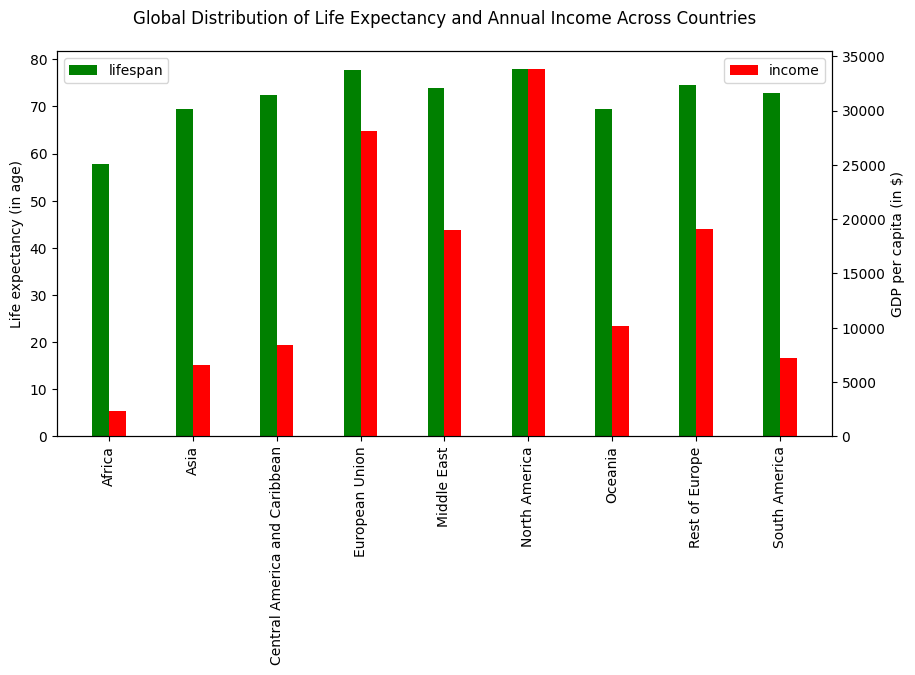

In [15]:
# the global evolution of life expectancy and GDP per capita across countries
temp_df = df.groupby('region')

# initialize the figure
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# set the positions of the bars on the x-axis
lifespan_positions = [i for i in range(9)]
income_positions = [i+0.2 for i in lifespan_positions]


# plot the bars
ax1.bar(lifespan_positions, temp_df['lifespan'].mean(), width=0.2, color='green', label='lifespan')
ax2.bar(income_positions, temp_df['income'].mean(), width=0.2, color='red', label='income')

# adjust the plot
ax1.set_xticks([i+0.1 for i in range(9)])
ax1.set_xticklabels(temp_df['income'].mean().index, rotation=90)
ax1.set_ylabel('Life expectancy (in age)')
ax1.legend(loc='upper left')
ax2.set_ylabel('GDP per capita (in $)')
ax2.legend(loc='upper right')
plt.title('Global Distribution of Life Expectancy and Annual Income Across Countries', y=1.05)
plt.show()

- The lifespan is the lowest in Africa with an average of 59 years, and the highest in both NA and EU with an average of 77, that's almost a different of 20 years, for other regions, the lifespan is between 69 and 74 years.
- The average annual income is also the lowest in Africa, and the highest in NA, with a difference of 33,000 dollars, we also see that the trend for the annual income and lifespan is the same, the higher the income on a country, the higher the lifespan of its people.

Given this disparity between the regions, and the evolution over the years we saw in the previous graph, we can say that the region, the year and the GDP per capita are associated with the life expectancy, the relationship is not causal, because we cannot say for example that moving from one year to another will cause an increase or decrease in the lifespan, but there is a correlation between these variables.

Now, let's analyze the health indicators, we will start with the mortality rate of the different ages (adults, children, infants), refering to the number of deaths per 1000 live births.

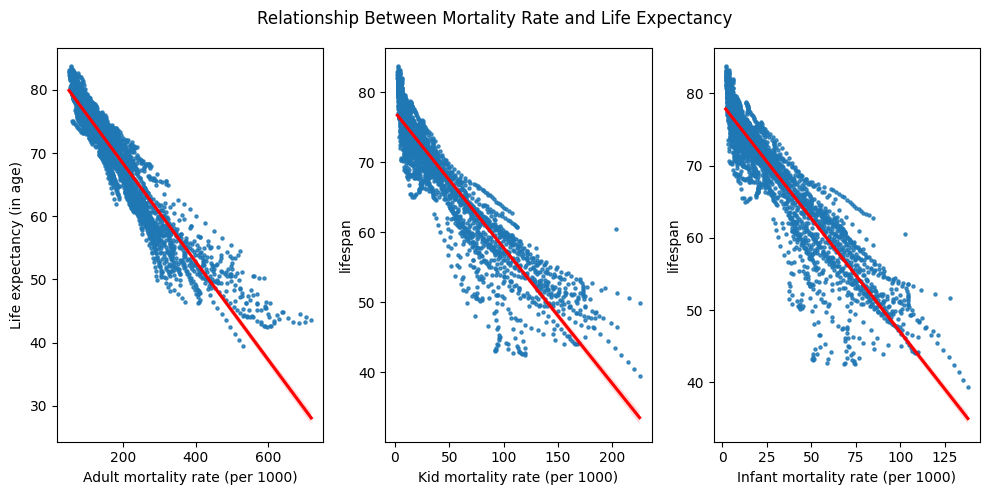

In [16]:
# relationship between mortality rate and life expectancy
fig, ax = plt.subplots(1, 3, figsize=(10, 5))

# plot the scatters
sns.regplot(data=df, x='adult_deaths', y='lifespan', scatter_kws={'s': 5}, line_kws={'color': 'red'}, ax=ax[0])
sns.regplot(data=df, x='kid_deaths', y='lifespan', scatter_kws={'s': 5}, line_kws={'color': 'red'}, ax=ax[1])
sns.regplot(data=df, x='infant_deaths', y='lifespan', scatter_kws={'s': 5}, line_kws={'color': 'red'}, ax=ax[2])

# adjust the plots
ax[0].set_xlabel('Adult mortality rate (per 1000)')
ax[0].set_ylabel('Life expectancy (in age)')
ax[1].set_xlabel('Kid mortality rate (per 1000)')
ax[2].set_xlabel('Infant mortality rate (per 1000)')
plt.suptitle('Relationship Between Mortality Rate and Life Expectancy')
plt.tight_layout()
plt.show()

- There is a strong relationship between mortality rate and lifespan, this relationship is negative, meaning that the higher the mortality rate, the lower the lifespan, and vice versa. This is logical, because the higher the mortality rate, the more people die, and the less people are alive, so the average lifespan will be lower.
- We also see a high density of points in lower values of mortality rate.

Next, we will look at the impact of drinking habits, the body mass index and the thinness on the lifespan.

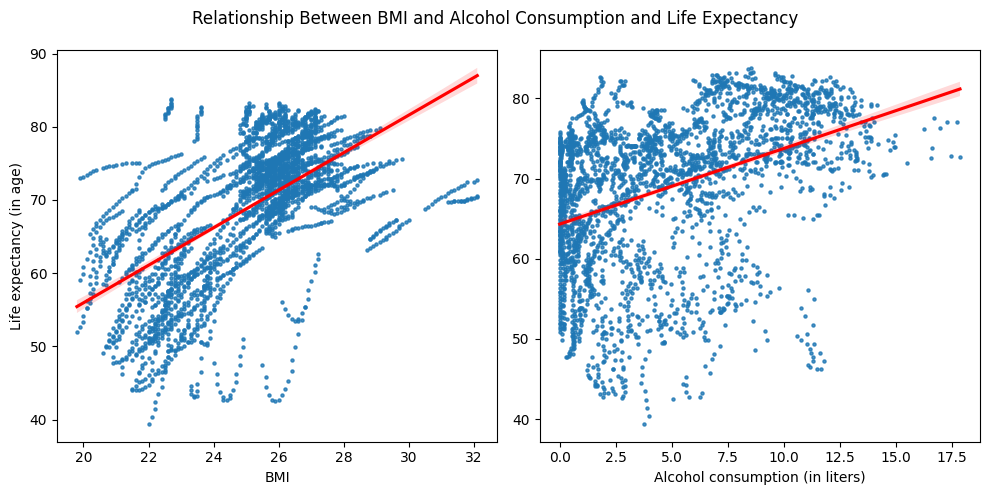

In [17]:
# create figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# bmi x lifespan
sns.regplot(data=df, x='bmi', y='lifespan', scatter_kws={'s': 5}, line_kws={'color': 'red'}, ax=ax[0])

# alcohol x lifespan
sns.regplot(data=df, x='alcohol', y='lifespan', scatter_kws={'s': 5}, line_kws={'color': 'red'}, ax=ax[1])

# # adjust the graph
ax[0].set_xlabel('BMI')
ax[0].set_ylabel('Life expectancy (in age)')
ax[1].set_xlabel('Alcohol consumption (in liters)')
ax[1].set_ylabel('')
plt.suptitle('Relationship Between BMI and Alcohol Consumption and Life Expectancy')
plt.tight_layout()
plt.show()

The relationship between BMI and lifespan is not very clear, we can distinguish different clusters of points, and we might think that with a normal to obese BMI we are more likely to have a higher lifespan, but that is not certain. We might as well bin the BMI into different categories and see if there is a difference in the lifespan.  
Moving to alcohol consumption, there is no clear pattern how it affects the lifespan, we can only see a random distribution of points, with a high density in the lower values of alcohol consumption.  
Let's keep up with skinness.

<Figure size 1000x1000 with 0 Axes>

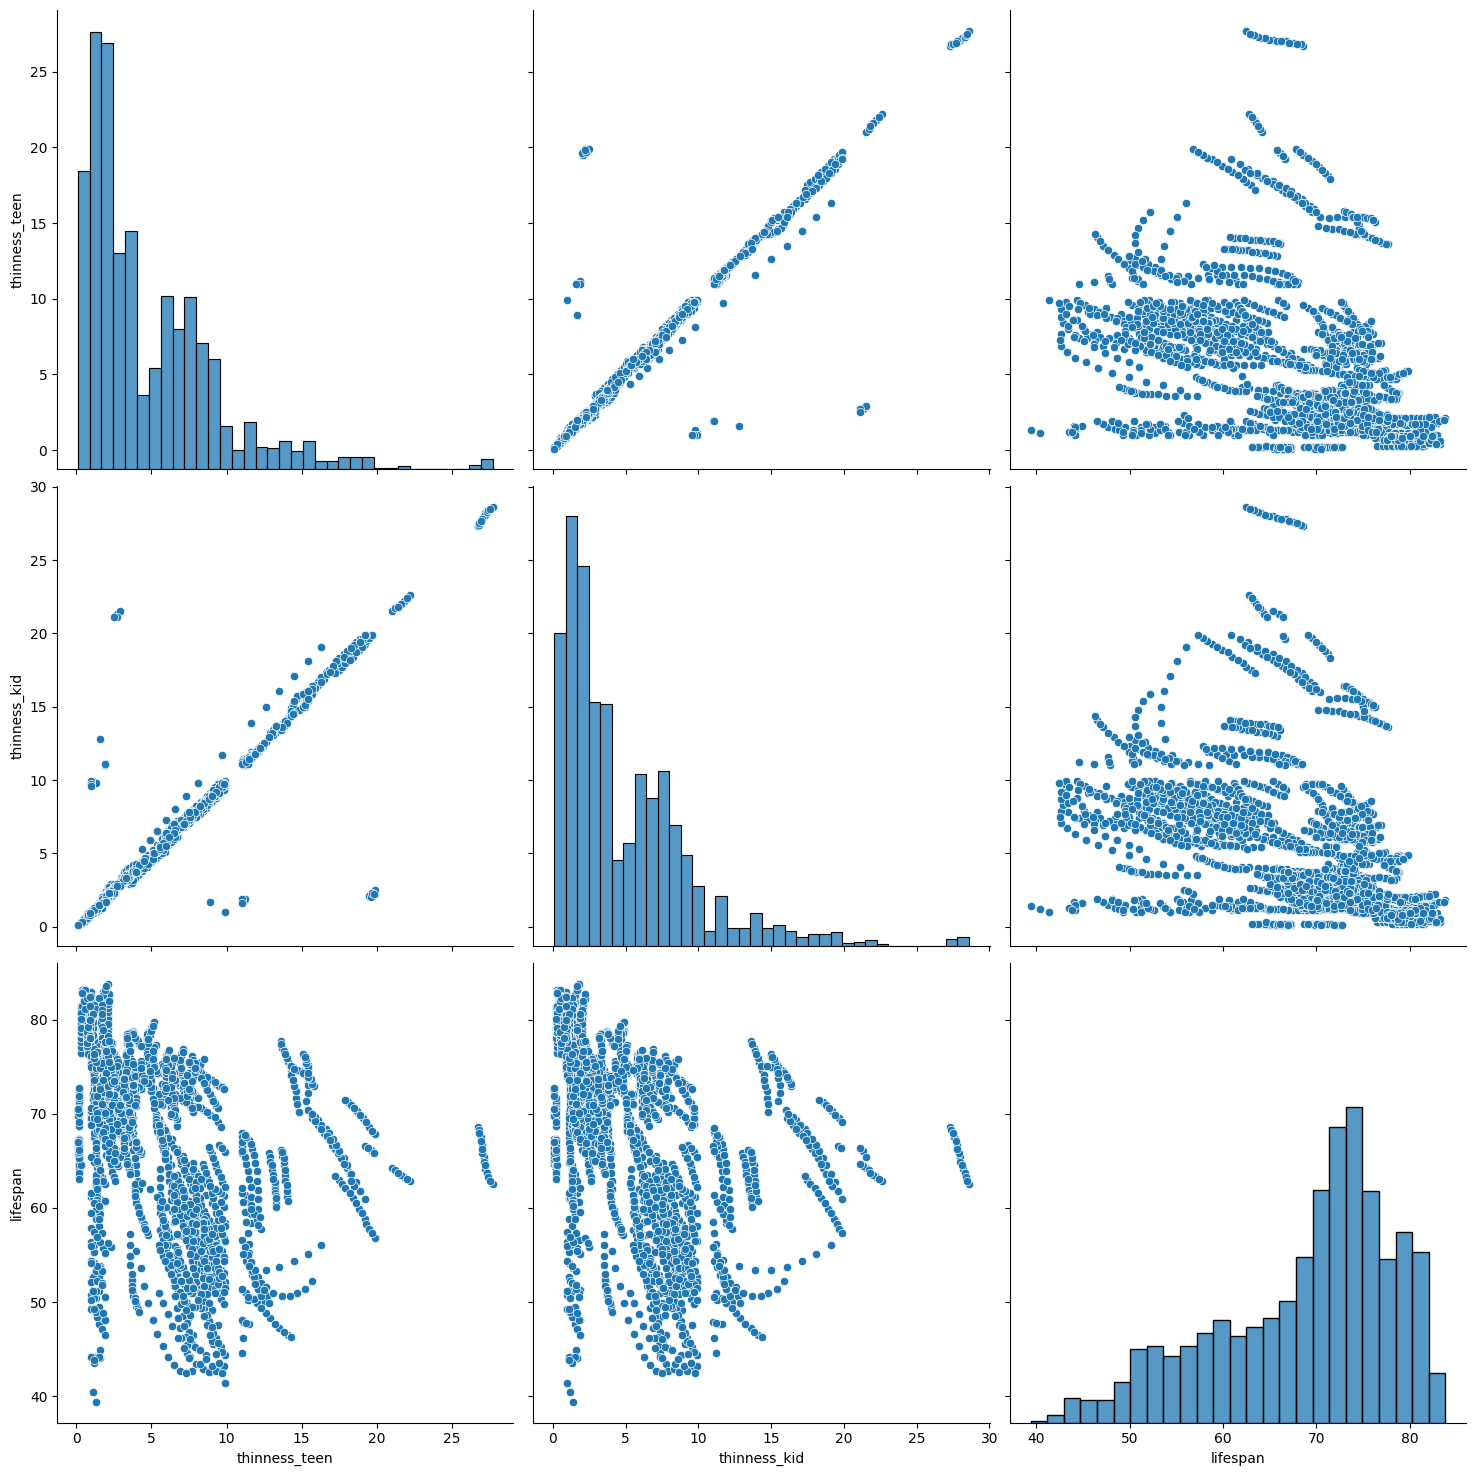

In [21]:
# create figure
plt.figure(figsize=(10, 10))
sns.pairplot(df[['thinness_teen', 'thinness_kid', 'lifespan']], height=5)
plt.show()

- First of all, there seems to be no relevant association between thinness and lifespan, we can see that the points are distributed randomly, and we might as well distinguish clusters of points with no clear pattern.
- Second, there is almost a perfect correlation between thinness in children and thinness in adults, this is logical, because the thinness in children is a consequence of the thinness in adults, and vice versa.

Let's look at a heatmap of the correlation between these features we have just mentioned.

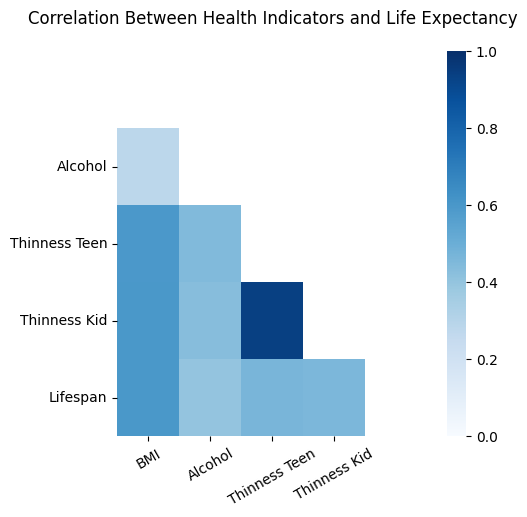

In [63]:
# create figure
plt.figure(figsize=(5, 5))

# plot the heatmap with a 0-1 range
sns.heatmap(np.abs(df[['bmi', 'alcohol', 'thinness_teen', 'thinness_kid', 'lifespan']].corr()), cmap='Blues', vmin=0, vmax=1, mask=np.triu(np.ones_like(df[['bmi', 'alcohol', 'thinness_teen', 'thinness_kid', 'lifespan']].corr(), dtype=bool)))

# adjust the plot
plt.xticks([i+0.5 for i in range(4)], ['BMI', 'Alcohol', 'Thinness Teen', 'Thinness Kid'], rotation=30)
plt.yticks([i+1.5 for i in range(4)], ['Alcohol', 'Thinness Teen', 'Thinness Kid', 'Lifespan'])
plt.title('Correlation Between Health Indicators and Life Expectancy', y=1.05)
plt.show()

- This heatmap emphasizes the strong correlation between thinness in children and thinness in adults.
- No linear relationship could be derived between alcohol and the other features, but we can see that thiness is associated with bmi a little bit.  
This leads to the conclusion that we can actually drop the alcohol feature, we can also drop the thinness features, or at least drop one of them because of the high correlation.

Next thing is to analyze the different features related to immunization coverage.

In [19]:
df.head()

,country,region,year,infant_deaths,kid_deaths,adult_deaths,alcohol,hepatitis_b,measles,bmi,polio,diphtheria,incidents_hiv,income,population_mln,thinness_teen,thinness_kid,schooling,lifespan,status
0,Turkiye,Middle East,2015,11.1,13.0,105.8240,1.32,97,65,27.8,97,97,0.08,11006,78.53,4.9,4.8,7.8,76.5,developing
1,Spain,European Union,2015,2.7,3.3,57.9025,10.35,97,94,26.0,97,97,0.09,25742,46.44,0.6,0.5,9.7,82.8,developed
2,India,Asia,2007,51.5,67.9,201.0765,1.57,60,35,21.2,67,64,0.13,1076,1183.21,27.1,28.0,5.0,65.4,developing
3,Guyana,South America,2006,32.8,40.5,222.1965,5.68,93,74,25.3,92,93,0.79,4146,0.75,5.7,5.5,7.9,67.0,developing
4,Israel,Middle East,2012,3.4,4.3,57.9510,2.89,97,89,27.0,94,94,0.08,33995,7.91,1.2,1.1,12.8,81.7,developed
